In [1]:
# Check if Poppler is installed
!command -v pdftotext > /dev/null && echo "Poppler is installed." || echo "Poppler is not installed. Please run 'brew install poppler'."

Poppler is installed.


In [2]:
from pathlib import Path
import shutil

import re

import base64
from dotenv import load_dotenv
from uuid import uuid4
from IPython.display import display, Markdown

from pdf2image import convert_from_path

from langchain_openai import ChatOpenAI

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import BaseOutputParser
from langchain_text_splitters import Language, RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore

from tenacity import retry, wait_exponential, stop_after_attempt
from tqdm import tqdm

from PIL import Image as PIL_Image

load_dotenv(override=True)

True

#### Configs

In [3]:
# doc
DOCUMENT_NAME = (
    "Fiche-aides-financieres-moins-de-18-ans_mise-a-jour-le-18-dec.-2024.pdf"
)

In [4]:
# Dir
DOC_DIR = Path("__file__").parent / "data/cash/seh/"
DOC_DIR.mkdir(parents=True, exist_ok=True)

IMG_DIR = Path("__file__").parent / "data/cash/seh/images"
if IMG_DIR.exists():
    for item in IMG_DIR.iterdir():
        if item.is_file():
            item.unlink()
        else:
            shutil.rmtree(item)
IMG_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# Document Path
DOCUMENT_PATH = DOC_DIR / DOCUMENT_NAME

In [6]:
# MLLM
MLLM_MODEL = "gpt-4o"
MLLM_TEMPERATURE = 0

mllm = ChatOpenAI(
    model=MLLM_MODEL,
    temperature=MLLM_TEMPERATURE,
)

#### Utils

In [7]:
def print_image(image_path):
    """print image in notebook"""
    pil_image = PIL_Image.open(image_path)
    original_width, original_height = pil_image.size

    # Resize the image
    new_width = 512
    new_height = int((new_width / original_width) * original_height)
    resized_image = pil_image.resize((new_width, new_height), PIL_Image.LANCZOS)

    return resized_image

In [8]:
def print_mk(text):
    """Prints text as markdown in Jupyter Notebook."""
    display(Markdown(text))

In [9]:
def encode_image(image_path):
    """Encodes an image to base64."""
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

#### Parse PDF

In [10]:
# Convert each page of the PDF to an image
images = convert_from_path(DOCUMENT_PATH, thread_count=4, fmt="JPEG", dpi=300)

In [11]:
# Add img_path to each page
pages = []
for image in enumerate(images):
    image_name = f"{str(uuid4())}.jpg"
    # Save the image to a file
    image_path = IMG_DIR / image_name
    image[1].save(image_path, "JPEG")

    encoded_image = encode_image(image_path)

    pages.append(
        Document(
            page_content="",
            metadata={
                "img_path": str(IMG_DIR / image_name),
                "img_encoded": encoded_image,
                "page": image[0] + 1,
            },
        )
    )

In [12]:
%%time
# Parse Images as Markdown

PARSING_PROMPT = """
**Objective:** Directly extract content from the input image (representing a document page) into Markdown format, maintaining the visual sequence and providing detailed descriptions for visual elements.

**Instructions:**

1.  **Sequential Extraction:** Process the image content following the natural reading order (e.g., top-to-bottom, left-to-right, respecting columns).
2.  **Text Extraction:** Extract all visible text blocks. Preserve approximate paragraph or line structure as observed on the page. Add Markdown syntax for title, headings, lists, and other formatting as appropriate.
3.  **Table Extraction:** Identify any tables. Extract their content (headers and rows) accurately and format them as standard Markdown tables. Place the Markdown table in the output sequence where it appears on the page.
4.  **Visual Element Description:**
    * Identify significant non-text visual elements (e.g., images, photographs, charts, graphs, diagrams, illustrations).
    * In the output sequence where the visual element appears, insert a detailed description enclosed within `<VISUAL ELEMENT>` and `</VISUAL ELEMENT>` tags.
    * **The description should be comprehensive and accurate, covering:**
        * The type of visual (e.g., "bar chart," "photograph," "flowchart").
        * The main subject or data represented.
        * Key features, trends, or objects depicted.
        * Any clearly legible text *within* the visual (like titles, labels, captions, data points).
    * **Example Format:**
        <VISUAL ELEMENT>
        Bar chart comparing sales figures for Q1-Q4 2024. Shows significant growth in Q3. Categories are Product A, Product B, Product C. Text labels include 'Quarterly Sales 2024', 'Sales (in $M)', and specific values on axes.
        </VISUAL ELEMENT>
5.  **Output Generation:** Combine the extracted text, Markdown tables, and the tagged visual descriptions into a single, continuous Markdown stream that reflects the original page order.
6.  **Strict Output:** Return *only* the generated Markdown content. Do not include any introductory phrases, concluding remarks, or other commentary outside the extracted content itself.
"""


@retry(
    stop=stop_after_attempt(3),
    wait=wait_exponential(multiplier=1, min=4, max=10),
)
def parse_image(image_encoded):
    class CustomMarkdownParser(BaseOutputParser):
        def parse(self, text: str) -> str:
            text = text.strip()
            fence_re = re.compile(r"```(?:\w+)?\s*(.*?)\s*```", flags=re.S)
            text = fence_re.sub(lambda m: m.group(1).strip(), text)
            return text

    image_message = {
        "type": "image_url",
        "image_url": {"url": f"data:image/jpeg;base64,{image_encoded}"},
    }
    text_message = {
        "type": "text",
        "text": PARSING_PROMPT,
    }

    message = HumanMessage(content=[text_message, image_message])

    output = mllm.invoke([message]).content
    output = CustomMarkdownParser().parse(output)
    return output


# Parse each page and print the response
for page in tqdm(pages):
    page.page_content = parse_image(page.metadata["img_encoded"])

100%|██████████| 24/24 [04:32<00:00, 11.34s/it]

CPU times: user 316 ms, sys: 127 ms, total: 443 ms
Wall time: 4min 32s


In [14]:
# visual inspection of the page#11
pages[10].__dict__

{'id': None,
 'metadata': {'img_path': 'data/cash/seh/images/c91909bf-9b51-4be3-a12f-627b6aef93dc.jpg',
  'img_encoded': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAzkCfYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3OiiisjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACi

In [17]:
# print extracted content in markdown
print(pages[10].page_content)

# Les aides financières au niveau fédéral – Crédits d’impôts et remboursements

## 05. Les dépenses pour l’accessibilité domiciliaire

vous permettent, si vous êtes propriétaire d’un logement ou d’une habitation, de demander un montant pour adapter ce logement afin que votre enfant ou personne à charge puisse y accéder, s’y déplacer et y accomplir les tâches de la vie quotidienne tout en réduisant les risques de blessures.

- Pour l’année d’imposition 2024, le montant maximal du crédit est de 20 000$.

- Pour demander ce remboursement, veuillez remplir la ligne 31285 – Dépenses pour l’accessibilité domiciliaire dans votre déclaration d’impôts.

<VISUAL ELEMENT>
Illustration of a dollar sign and a gear icon, representing financial and technical aspects of accessibility adaptations.
</VISUAL ELEMENT>

<VISUAL ELEMENT>
Highlighted text in a yellow circle: "Ce soutien financier est principalement axé sur des adaptations visant à pallier des limitations physiques. Nous vous invitons à bien 

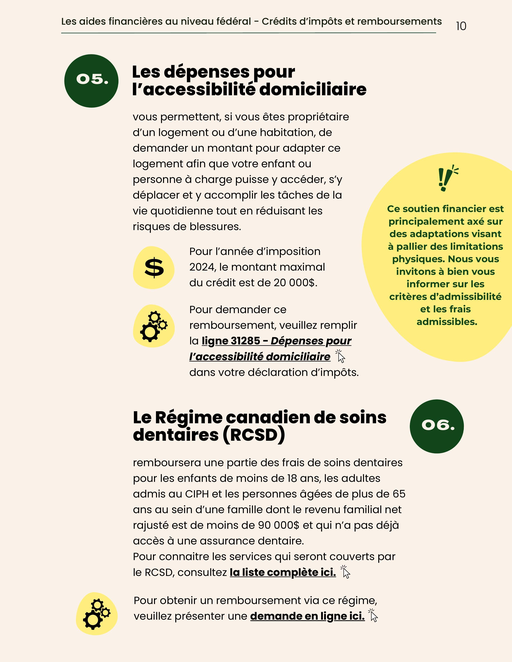

In [ ]:
## NOTE: Uncomment the following line to print the image in the notebook
# print_image(pages[10].metadata["img_path"])

#### Convert Pages into Chunks

In [18]:
# Split the parsed pages into smaller chunks
md_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN, chunk_size=1200, chunk_overlap=200
)

chunks = md_splitter.split_documents(pages)
print(f"Total chunks: {len(chunks)}")

Total chunks: 42


In [19]:
# visual inspection the chunk#3
chunks[3].__dict__

{'id': None,
 'metadata': {'img_path': 'data/cash/seh/images/05930afe-b805-4270-806b-5703cecde1c1.jpg',
  'img_encoded': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAzkCfYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3OiiisjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACi

In [20]:
# print extracted content in markdown
print_mk(chunks[3].page_content)

# Les aides financières au niveau fédéral

Pour avoir droit aux aides financières fédérales, votre enfant ou la personne à votre charge doit être admis au Crédit d’impôt pour personnes handicapées (CIPH).

![Icone de document] Pour accéder à ce crédit, il faut compléter et soumettre le **formulaire T2201 – Crédit d’impôt pour personnes handicapées** (CIPH).

Ce document devra être complété par un **médecin de famille, un infirmier praticien ou un autre spécialiste** confirmant les limitations et les besoins de la personne autiste.

![Icone de bureau] Le formulaire T2201 pourra être envoyé à votre **bureau fiscal de l’Agence du Revenu du Canada (ARC)** par la poste ou par dépôt numérique dans *Mon dossier ARC* à tout moment de l’année afin qu’il soit ajouté à votre dossier d’impôts fédéral.

Après réception du formulaire, l’ARC déterminera l’admissibilité (ce n’est pas automatique). **Vous serez avisé par courrier de leur décision.** Le délai habituel de traitement d’une demande est d’au moins deux mois.

**CERTAINES DEMANDES DE CIPH APPROUVÉES EXPIRENT APRÈS UN CERTAIN NOMBRE D’ANNÉES.**

In [21]:
# Sanity check of the chunks

low_quality_chunks = []
for i, chunk in enumerate(chunks):
    # Check if the chunk is too small or too large
    if len(chunk.page_content) < 100 or len(chunk.page_content) > 1200:
        low_quality_chunks.append(chunk)
print(f"Total low quality chunks: {len(low_quality_chunks)}/{len(chunks)}")

Total low quality chunks: 5/42


#### Cleanup

In [22]:
# Delete images folder
shutil.rmtree(IMG_DIR)